In [1]:
!pip install pmdarima
!pip install prophet

#Importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from prophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Data Pre-processing**

In [2]:
df=pd.read_csv("/content/drive/MyDrive/IMT 574 Final Project/SPD_Crime_Data__2008-Present.csv") #Source: https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5
df.isna().sum() #Checking for nulls
df.dropna(subset=['Offense Start DateTime','Precinct','Sector','Beat'],inplace=True) #Dropping NAs from offense start time
df.loc[:,'Offense Start DateTime']=pd.to_datetime(df['Offense Start DateTime']) #Covnerting start time to datetimeindex
df['date']=pd.to_datetime(df['Offense Start DateTime'].dt.strftime('%Y-%m-%d')) #extracting day level datetime in 'date' column

df=pd.DataFrame(df.groupby(by=['date'])['Offense ID'].nunique()).reset_index() #Grouping dataframe to get offence counts at given level
df=df[(df['date'].dt.year>=2008) & (df['date'].dt.year<=2019)] #Selecting entries post 2008 and pre-2019
df=df.rename(columns={'date':'Unnamed: 0', 'Offense ID':'Offence Count'})

Text(0.5, 1.0, 'Number of crimes in Seattle over time')

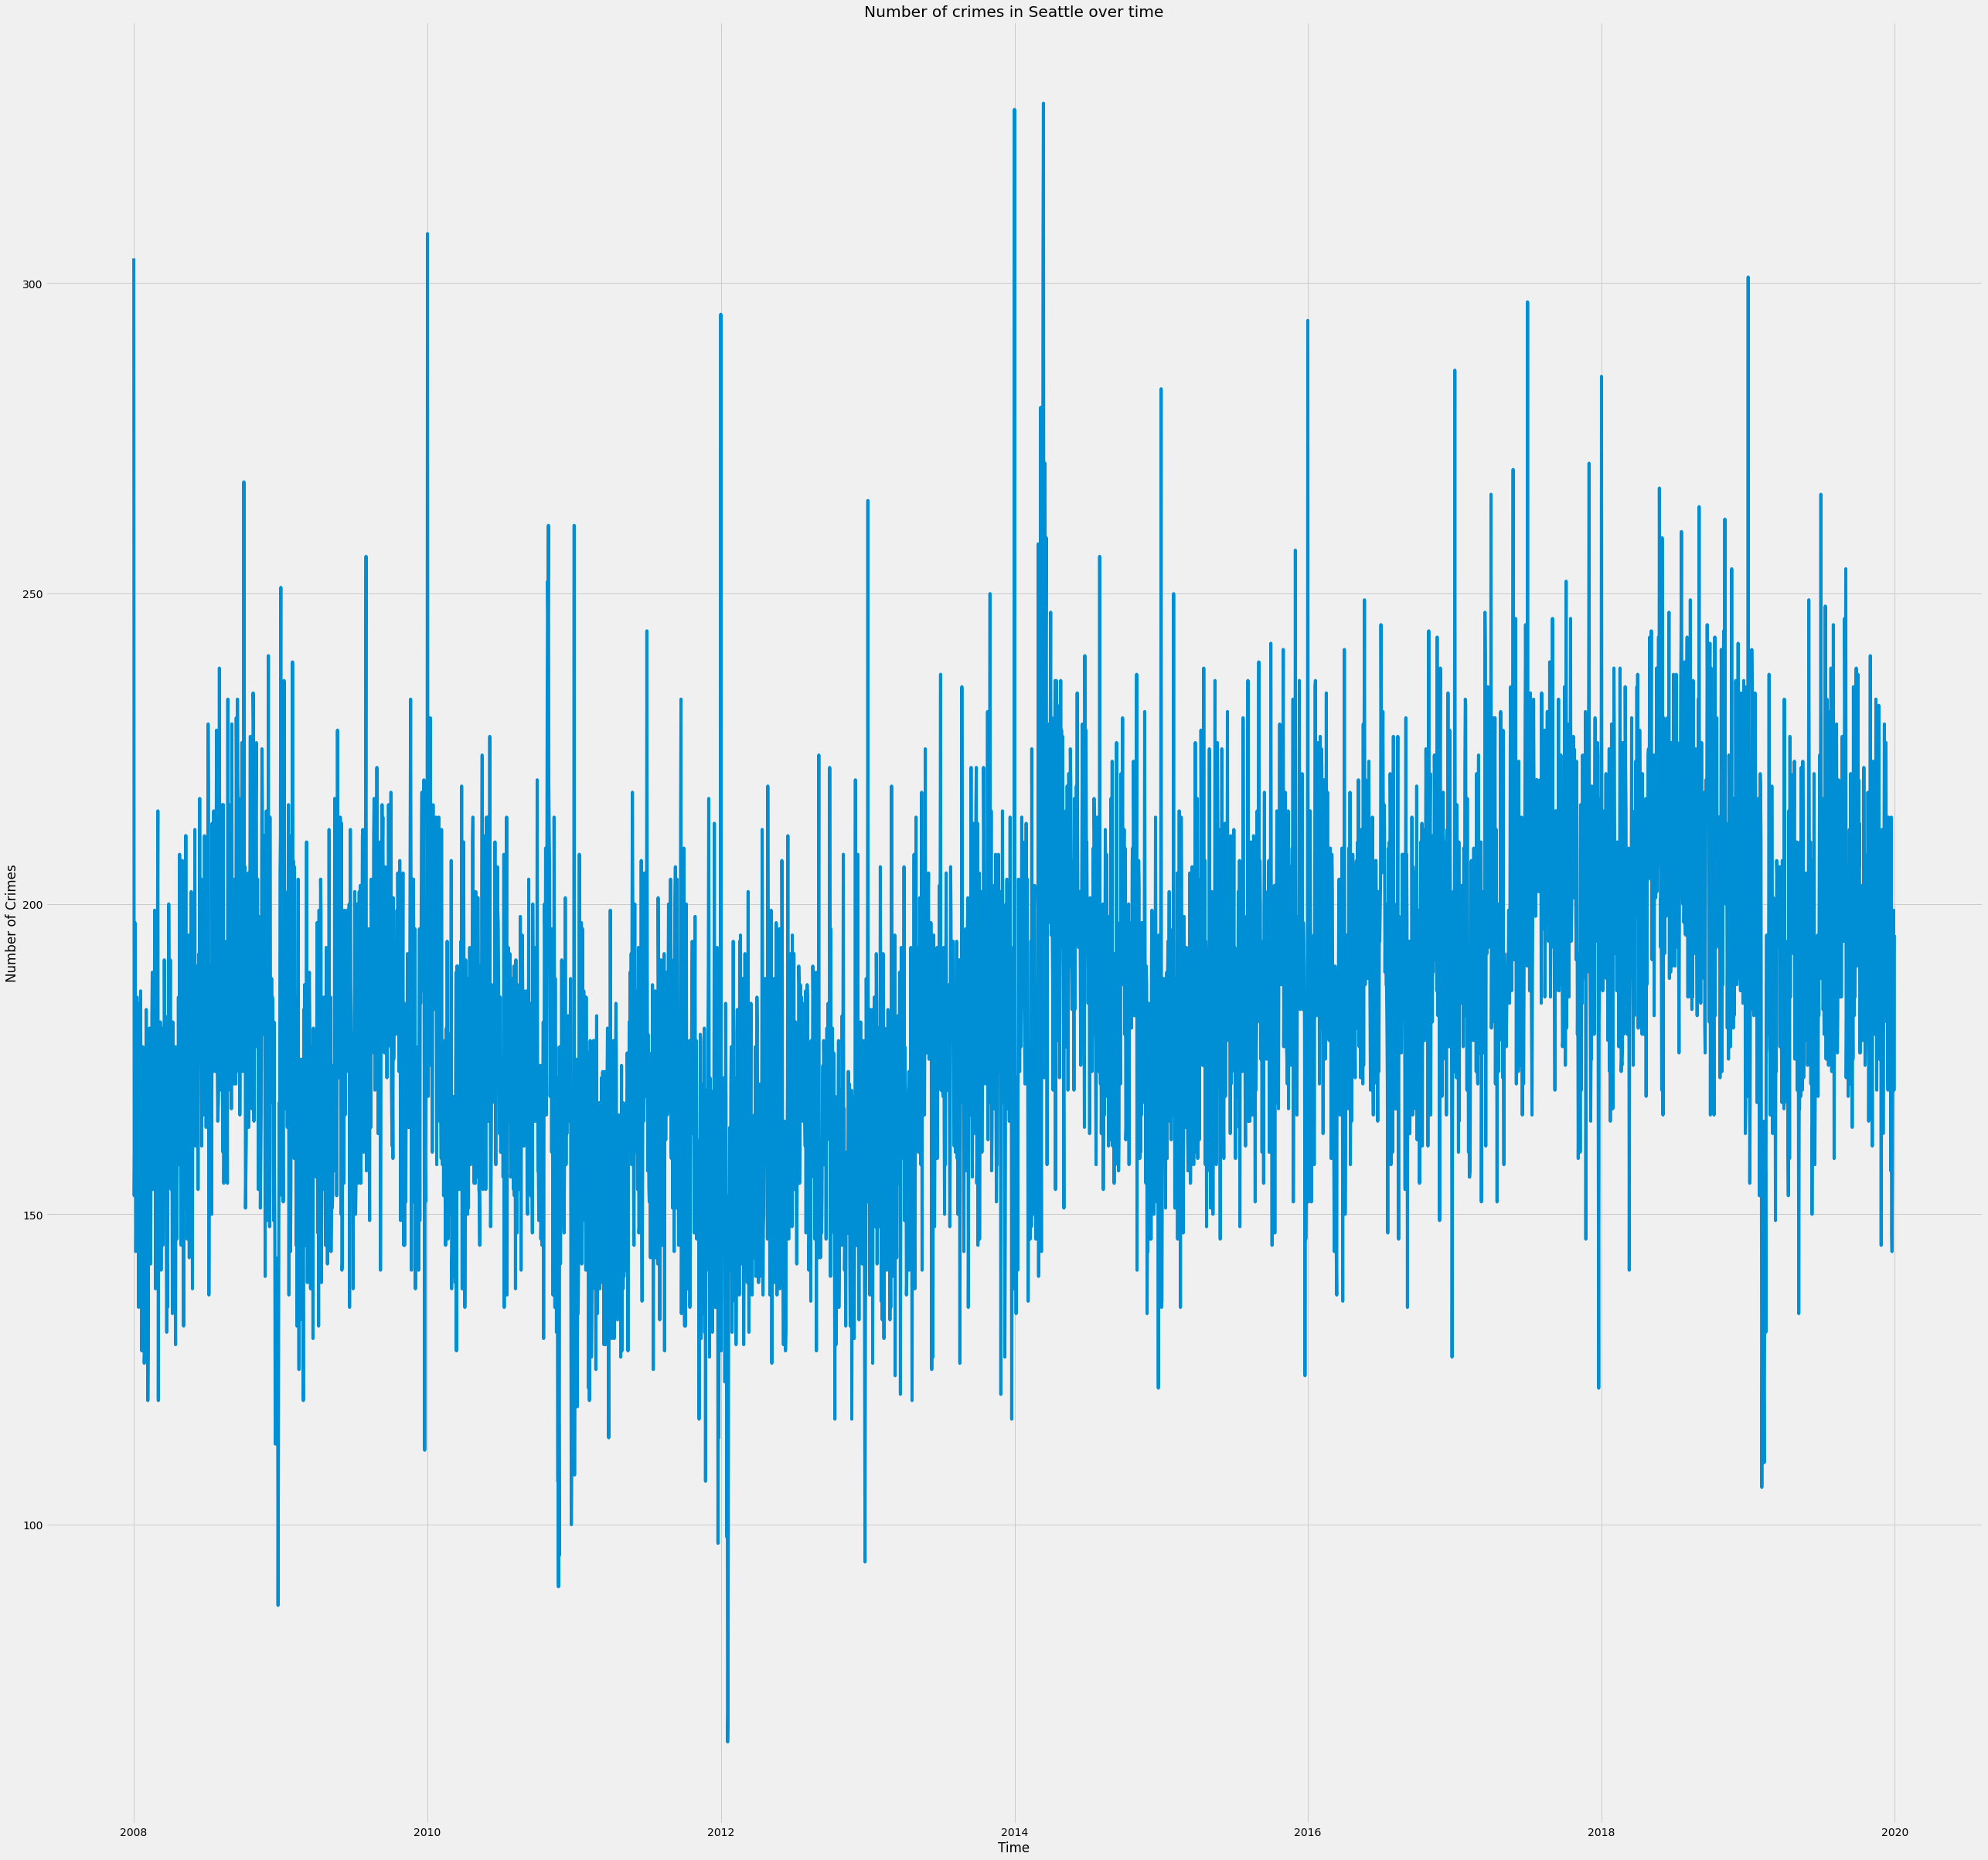

In [4]:
#Plotting offence count over years
plt.style.use('fivethirtyeight')
plt.figure(figsize=(40, 40))
plt.plot(df["Unnamed: 0"], df["Offence Count"])
plt.xlabel('Time')
plt.ylabel('Number of Crimes')
plt.title('Number of crimes in Seattle over time')

**ARIMA**

Text(0.5, 1.0, 'Number of crimes in Seattle over time (After Processing)')

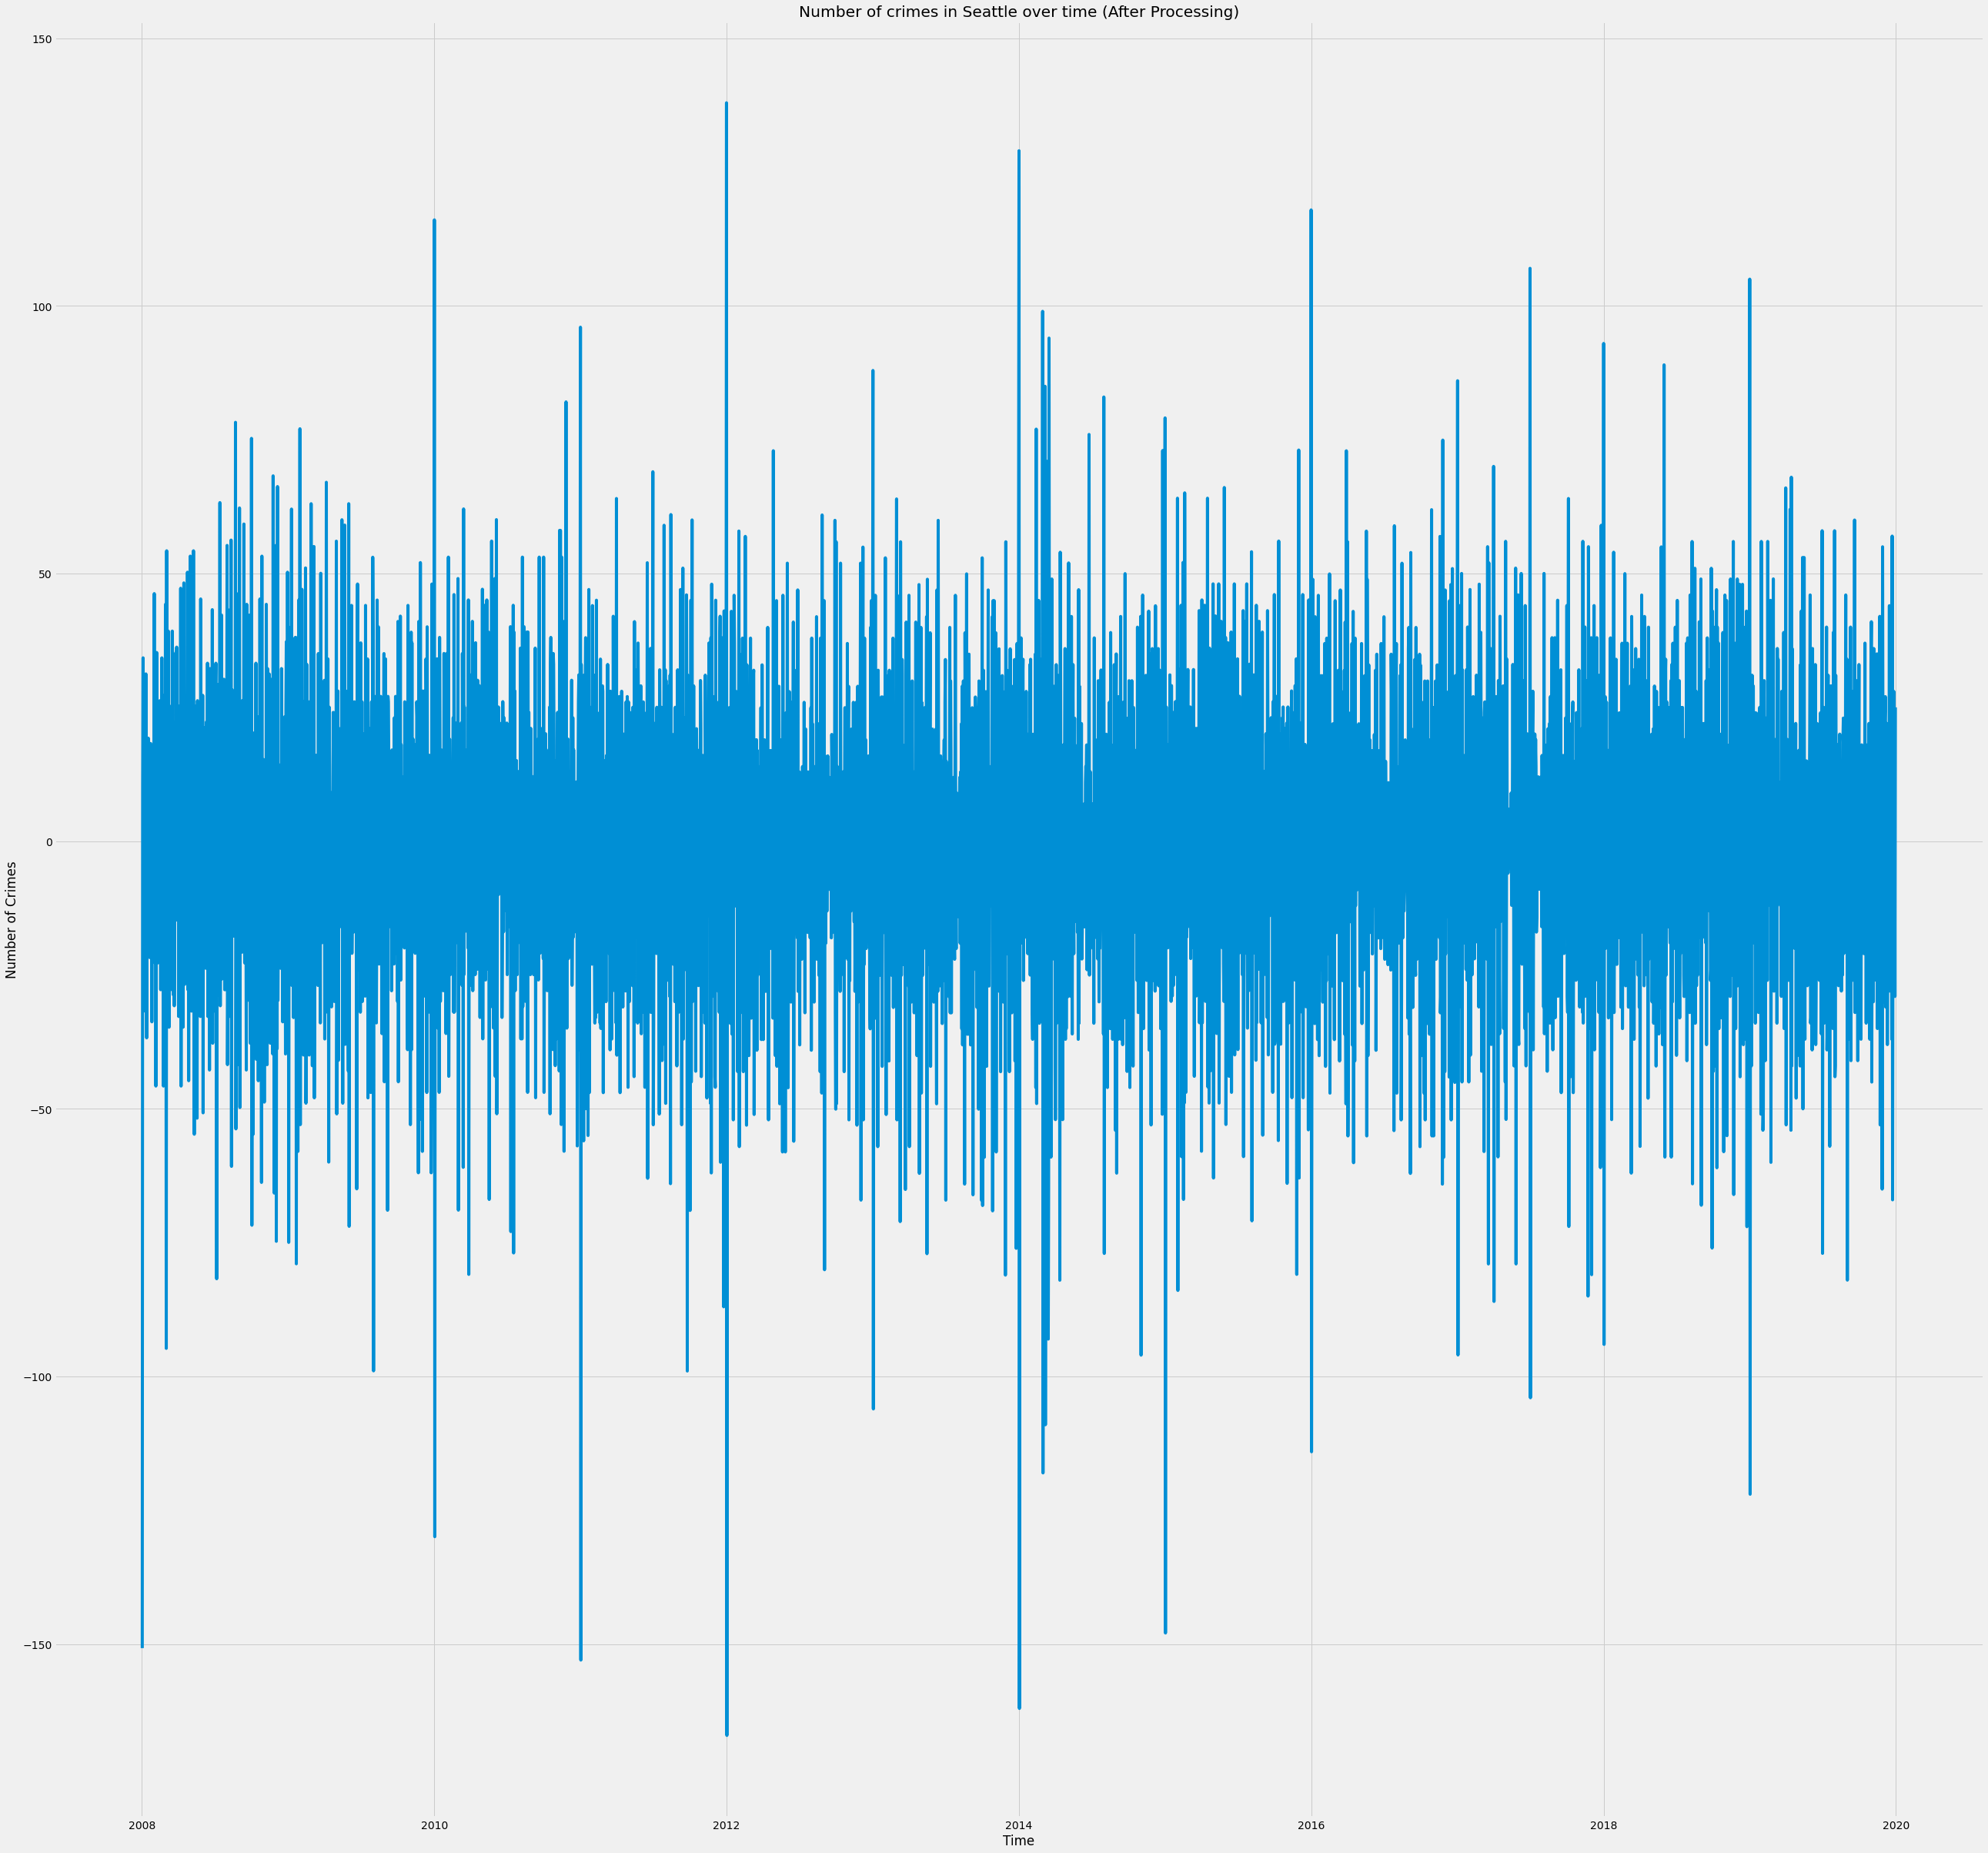

In [9]:
#Adjusting for trend using diff() method
df1=df.copy()
df1['Offence Count']=df1['Offence Count'].diff()
df1.dropna(inplace=True)

df1['year']=df1['Unnamed: 0'].dt.year #Creating a year column

# #Removing Seasonality
seas=pd.DataFrame(df1.groupby('year')['Offence Count'].mean()).reset_index()
seas.columns=['year','seas']
df1=df1.merge(seas,how='left',left_on='year',right_on='year')
df1['Offence Count']=df1['Offence Count']-df1['seas']

df1=df1[['Unnamed: 0','Offence Count']]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(40, 40))
plt.plot(df1["Unnamed: 0"], df1["Offence Count"])
plt.xlabel('Time')
plt.ylabel('Number of Crimes')
plt.title('Number of crimes in Seattle over time (After Processing)')

In [10]:
#Determining stationarity
print(adfuller(df1['Offence Count'])[1]) #ADF test to determine stationarity
print("The p-value is less than 0.05 hence the data seems to be stationary")

2.0831983396102784e-30
The p-value is less than 0.05 hence the data seems to be stationary


RMSE: 26.383837103831684
R-squared: -0.008199494834048915


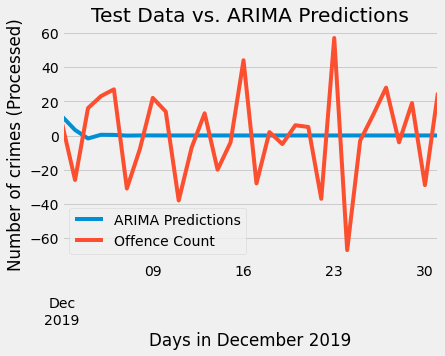

In [11]:
# Setting date as the index
df1.set_index('Unnamed: 0', inplace=True)
df1.index.name=None    

#Train test split
train=df1.iloc[:-30]
test=df1.iloc[-30:] #Setting aside 30 days for testing


#ARIMA training 1
arima=ARIMA(train['Offence Count'],order=(3,0,1))
arima=arima.fit()

#ARIMA testing 1
start=len(train)
end=len(train)+len(test)-1
pred=arima.predict(start=start,end=end).rename('ARIMA Predictions')
pred.plot(legend=True)
test['Offence Count'].plot(legend=True)
plt.ylabel('Number of crimes (Processed)')
plt.xlabel('Days in December 2019')
plt.title('Test Data vs. ARIMA Predictions')

#Quantifying the results on the test set 1
mse=mean_squared_error(test, pred)
rmse=np.sqrt(mse)
print("RMSE:", rmse)

r2=r2_score(test, pred)
print("R-squared:", r2)

RMSE: 24.761082120520275
R-squared: 0.1120064676412913


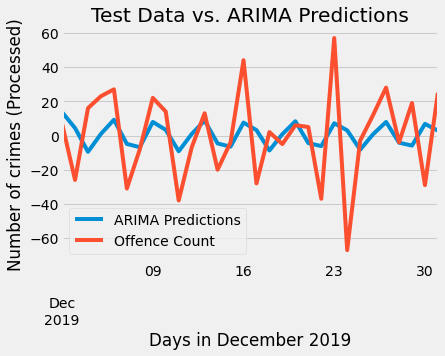

In [12]:
#ARIMA training 2
arima=ARIMA(train['Offence Count'],order=(3,0,3))
arima=arima.fit()

#ARIMA testing 2
start=len(train)
end=len(train)+len(test)-1
pred=arima.predict(start=start,end=end).rename('ARIMA Predictions')
pred.plot(legend=True)
test['Offence Count'].plot(legend=True)
plt.ylabel('Number of crimes (Processed)')
plt.xlabel('Days in December 2019')
plt.title('Test Data vs. ARIMA Predictions')

#Quantifying the results on the test set 2
mse=mean_squared_error(test, pred)
rmse=np.sqrt(mse)
print("RMSE:", rmse)

r2=r2_score(test, pred)
print("R-squared:", r2)

RMSE: 24.24088288179369
R-squared: 0.14892579413300822


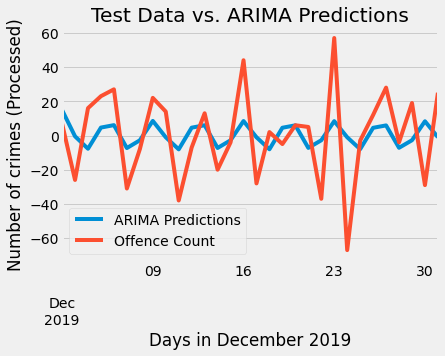

In [13]:
#ARIMA training 3
arima=ARIMA(train['Offence Count'],order=(3,0,6))
arima=arima.fit()

#ARIMA testing 3
start=len(train)
end=len(train)+len(test)-1
pred=arima.predict(start=start,end=end).rename('ARIMA Predictions')
pred.plot(legend=True)
test['Offence Count'].plot(legend=True)
plt.ylabel('Number of crimes (Processed)')
plt.xlabel('Days in December 2019')
plt.title('Test Data vs. ARIMA Predictions')

#Quantifying the results on the test set 3
mse=mean_squared_error(test, pred)
rmse=np.sqrt(mse)
print("RMSE:", rmse)

r2=r2_score(test, pred)
print("R-squared:", r2)

RMSE: 24.797598076649077
R-squared: 0.10938543173582449


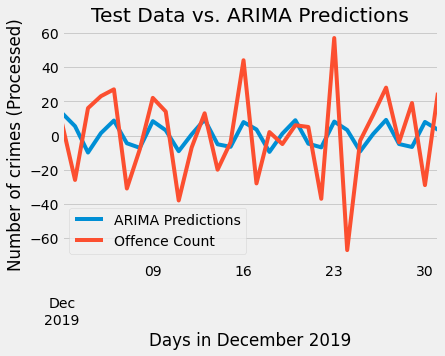

In [14]:
#ARIMA training 4
arima=ARIMA(train['Offence Count'],order=(4,0,6))
arima=arima.fit()

#ARIMA testing 1
start=len(train)
end=len(train)+len(test)-1
pred=arima.predict(start=start,end=end).rename('ARIMA Predictions')
pred.plot(legend=True)
test['Offence Count'].plot(legend=True)
plt.ylabel('Number of crimes (Processed)')
plt.xlabel('Days in December 2019')
plt.title('Test Data vs. ARIMA Predictions')

#Quantifying the results on the test set 1
mse=mean_squared_error(test, pred)
rmse=np.sqrt(mse)
print("RMSE:", rmse)

r2=r2_score(test, pred)
print("R-squared:", r2)

**Prophet Model**

In [44]:
#Train test split
train2=df.iloc[:-30]
test2=df.iloc[-30:] #Setting aside 30 days for testing
test2=test2.rename(columns={'Unnamed: 0': 'ds', 'Offence Count': 'y'})

train2=train2.rename(columns={'Unnamed: 0': 'ds', 'Offence Count': 'y'})
train2.head()
#Defining the model
m=Prophet()

# Add yearly seasonality
m.add_seasonality(name='yearly', period=365, fourier_order=10)

# Fit the model to the data
m.fit(train2)

# Make predictions for a year in the future
future = m.make_future_dataframe(periods=30)
forecast = pd.DataFrame(m.predict(future))

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplc59c9ao/yjcx906q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplc59c9ao/c877d3jo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87552', 'data', 'file=/tmp/tmplc59c9ao/yjcx906q.json', 'init=/tmp/tmplc59c9ao/c877d3jo.json', 'output', 'file=/tmp/tmplc59c9ao/prophet_modelau7ri9za/prophet_model-20230311040719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:07:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [40]:
forecast1=forecast[['ds','yhat']].tail(30).set_index('ds')
forecast1.index.name=None
forecast1.columns=['Prophet Predictions']
test2.set_index('ds',inplace=True)
test2.index.name=None
test2.columns=['Offence Count']

Text(0.5, 1.0, 'Test Data vs. Prophet Predictions')

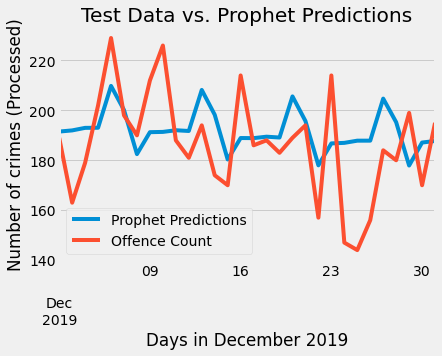

In [41]:
#Plotting predictions against the ground truth
forecast1.plot(legend=True)
test2['Offence Count'].plot(legend=True)
plt.ylabel('Number of crimes (Processed)')
plt.xlabel('Days in December 2019')
plt.title('Test Data vs. Prophet Predictions')

In [42]:
#Quantifying the results on the test set
mse=mean_squared_error(test2, forecast1)
rmse=np.sqrt(mse)
print("RMSE:", rmse)

r2=r2_score(test2, forecast1)
print("R-squared:", r2)

RMSE: 20.277270851621587
R-squared: 0.03929036210906389
